In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph/myKernels')
import mmdutils
import importlib
importlib.reload(sys.modules['mmdutils'])
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
import RandomWalk as rw
import scipy


In [6]:
from importlib import reload  
foo = reload(mg)

noise1 = 0.1
block_label_probability1 = 1.0 - noise1
noise1 = noise1/2.0

noise2 = 0.14
block_label_probability2 = 1.0 - noise2
noise2 = noise2/2.0

n1 = 200
n2 = 200


# Initialize Graph generator class
probs_1 = np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
label_pmf_1 = np.array([[block_label_probability1, noise1, noise1], [noise1, block_label_probability1, noise1], [noise1, noise1, block_label_probability1]])
sizes_1 = [30, 20, 25]
bg1 = mg.SBMGraphs(n = n1, sizes = sizes_1, P = probs_1, l = 'BlockLabelling', params= {'label_pmf':label_pmf_1}, fullyConnected=True)

probs_2 = np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
label_pmf_2 = np.array([[block_label_probability2, noise2, noise2], [noise2, block_label_probability2, noise2], [noise2, noise2, block_label_probability2]])
sizes_2 = [30, 20, 25]
bg2 = mg.SBMGraphs(n = n2, sizes = sizes_2, P = probs_2, l = 'BlockLabelling', params= {'label_pmf':label_pmf_2}, fullyConnected=True)

bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

 15%|█▍        | 1056/7260.0 [08:00<47:04,  2.20it/s] 


In [14]:
G = Gs[0]
A = scipy.sparse.csr_matrix(nx.linalg.adjacency_matrix(G), dtype=np.float64)
D_sq_inv = scipy.sparse.dia_matrix(([1/ np.sqrt(float(d[1])) for d in G.degree()], 0), shape = (A.shape[0], A.shape[0]))
D_sq_inv.dot(A).dot(D_sq_inv)

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 34 stored elements in Compressed Sparse Row format>

# ARKU (allows weights and edge directions) approximation

In [181]:

importlib.reload(sys.modules['RandomWalk'])
rw_kernel = rw.RandomWalk(Gs, 0.001)
K = rw_kernel.fit_ARKU(r = 6)


100%|██████████| 820/820.0 [00:01<00:00, 504.41it/s]


# ARKU plus faster

In [186]:
importlib.reload(sys.modules['RandomWalk'])
rw_kernel = rw.RandomWalk(Gs, 0.1)
K = rw_kernel.fit_ARKU_plus(r = 14, normalize_adj=False)

100%|██████████| 820/820.0 [00:07<00:00, 105.61it/s]


#  ARK-L, allow labels

First we have to fetch all labels generated, usually this should be known

In [3]:
label_list = []
for G in Gs:
    label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

label_list = np.unique(np.concatenate(label_list))


In [7]:
importlib.reload(sys.modules['RandomWalk'])
rw_kernel = rw.RandomWalk(Gs, 0.01)
K = rw_kernel.fit_ARKL(r = 10, label_list = label_list, normalize_adj=False)

100%|██████████| 80200/80200.0 [02:46<00:00, 481.62it/s]


# Fit random walk with k walks, no approximation is going to be slow.

In [56]:
importlib.reload(sys.modules['RandomWalk'])
rw_kernel = rw.RandomWalk(Gs, 0.1)
mu_vec = np.power(0.1,range(6+1)) / np.array([np.math.factorial(i) for i in np.arange(6+1)])
K = rw_kernel.fit_random_walk(mu_vec, k = 6,  r = 2, normalize_adj=True )

100%|██████████| 820/820.0 [00:03<00:00, 207.78it/s]


# Fit exponential random walk, no approximation is slow

In [6]:
importlib.reload(sys.modules['RandomWalk'])
rw_kernel = rw.RandomWalk(Gs, 0.1)
K = rw_kernel.fit_exponential(r = 2, normalize_adj=True )

100%|██████████| 5050/5050.0 [00:38<00:00, 132.63it/s]


# The following is the grakel package, using kernel type:exponential is slow.

In [16]:
kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.01, 'with_labels':False}]
# kernel = [{"name":'odd_sth', 'h':3}]
# kernel = [{"name": "propagation", "t_max": 4, "w":1, "M":'TV'}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=False, n_jobs= 1)
K = init_kernel.fit_transform(gk.graph_from_networkx(Gs, node_labels_tag='label')  )


In [191]:
K

array([[3602.9009149 , 3603.12082169, 3603.00879201, ..., 3602.85449959,
        3602.81754121, 3602.94980227],
       [3603.12082169, 3603.35745756, 3603.2368998 , ..., 3603.07087334,
        3603.03110099, 3603.17343461],
       [3603.00879201, 3603.2368998 , 3603.12068998, ..., 3602.96064491,
        3602.92230729, 3603.05950512],
       ...,
       [3602.85449959, 3603.07087334, 3602.96064491, ..., 3602.80883049,
        3602.77246649, 3602.90259993],
       [3602.81754121, 3603.03110099, 3602.92230729, ..., 3602.77246649,
        3602.73657592, 3602.86501462],
       [3602.94980227, 3603.17343461, 3603.05950512, ..., 3602.90259993,
        3602.86501462, 3602.99952004]])

# Hypothesis

In [8]:
importlib.reload(sys.modules['RandomWalk'])
# rw_kernel = rw.RandomWalk(Gs, 0.01)
# K = rw_kernel.fit_ARKU_plus(r = 6)

#mu_vec = np.power(0.1,range(6+1)) / np.array([np.math.factorial(i) for i in np.arange(6+1)])
#K = rw_kernel.fit_random_walk(mu_vec, k = 6,  r = 6, row_normalize_adj=True )

#K = rw_kernel.fit_exponential(r = None, normalize_adj=False )

# label_list = []
# for G in Gs:
#     label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

# label_list = np.unique(np.concatenate(label_list))
# K = rw_kernel.fit_ARKL(r = 6, label_list = label_list, normalize_adj=False, row_normalize_adj=False)

MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)
print(kernel_hypothesis.p_values)
print(kernel_hypothesis.sample_test_statistic['MMD_b'])
print(kernel_hypothesis.boot_test_statistic['MMD_b'])
print(np.all(kernel_hypothesis.boot_test_statistic['MMD_b']>0))

{'MMD_b': 0.0013333333333333333, 'MMD_u': 0.0013333333333333333}
2.8393447208600264
[0.61648823 0.59900873 0.49126779 ... 0.25539261 1.86571959 0.660144  ]
True


<AxesSubplot:>

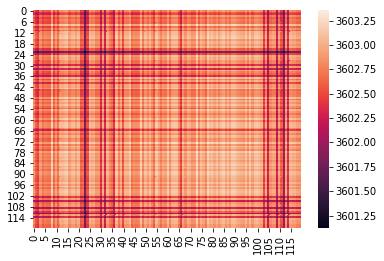

In [200]:
import seaborn as sns

sns.heatmap(K)